# Importaciones

In [1]:
from imports import *                    # pandas, numpy, etc.
from trading_environment import (
    DataManager,
    Optimizer,
    PerformanceAnalyzer,
    ReportManager,
    RiskManager,
    DATA_DIR,
    MAX_FILE_SIZE,
    REPORT_DIR
)
from strategies import (
    MovingAverageCrossStrategy,
    DcaStrategy,
    DonchianBreakoutStrategy,
    ADXTrendStrategy,
    ROCStrategy,
    MACDStrategy,
    BollingerMeanRevStrategy,
    RSIStrategy,
    PairTradingStrategy,
    VWAPStrategy
)

d:\Desktop\Algorithmic Trading\Prueba\venv310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Strategies

2025-06-24 00:17:02,043 - INFO - Cargados 732 registros de caché (1 archivos)
2025-06-24 00:17:02,090 - WARNING - Grid skip {'short_window': 50, 'long_window': 50}: short_window debe ser menor que long_window
[I 2025-06-24 00:17:02,108] A new study created in memory with name: no-name-1c30906c-22f3-42fa-a534-3f1492dd2195
[I 2025-06-24 00:17:02,121] Trial 0 finished with value: 0.8958767434453544 and parameters: {'short_window': 22, 'long_window': 193}. Best is trial 0 with value: 0.8958767434453544.
[I 2025-06-24 00:17:02,130] Trial 1 finished with value: 0.32816807539754717 and parameters: {'short_window': 38, 'long_window': 140}. Best is trial 1 with value: 0.32816807539754717.
[I 2025-06-24 00:17:02,140] Trial 2 finished with value: 0.044517526815327564 and parameters: {'short_window': 12, 'long_window': 73}. Best is trial 2 with value: 0.044517526815327564.
[I 2025-06-24 00:17:02,154] Trial 3 finished with value: -0.48360528575146683 and parameters: {'short_window': 7, 'long_window


Processing strategy type: MA Cross
  Grid best    — Sharpe 0.6424 with {'short_window': 5, 'long_window': 50}


[I 2025-06-24 00:17:02,269] Trial 10 finished with value: -0.16298348922496728 and parameters: {'short_window': 5, 'long_window': 167}. Best is trial 3 with value: -0.48360528575146683.
[I 2025-06-24 00:17:02,286] Trial 11 finished with value: -0.16218615428671246 and parameters: {'short_window': 32, 'long_window': 164}. Best is trial 3 with value: -0.48360528575146683.
[I 2025-06-24 00:17:02,307] Trial 12 finished with value: -0.47327139135182694 and parameters: {'short_window': 31, 'long_window': 160}. Best is trial 3 with value: -0.48360528575146683.
[I 2025-06-24 00:17:02,324] Trial 13 finished with value: 0.3383563828897946 and parameters: {'short_window': 47, 'long_window': 109}. Best is trial 3 with value: -0.48360528575146683.
[I 2025-06-24 00:17:02,344] Trial 14 finished with value: 0.5646615873442696 and parameters: {'short_window': 30, 'long_window': 51}. Best is trial 3 with value: -0.48360528575146683.
[I 2025-06-24 00:17:02,370] Trial 15 finished with value: -0.0689644916

  Bayesian best— Sharpe 1.2146 with {'short_window': 49, 'long_window': 121}


[I 2025-06-24 00:17:04,773] A new study created in memory with name: no-name-b3439252-4595-4809-8aa2-bc9037ee0b9a


  DE best      — Sharpe 1.3291 with {'short_window': 41, 'long_window': 50}

Processing strategy type: DCA
  Grid best    — Sharpe 1.3091 with {'amount': 500, 'freq': 'W'}


[I 2025-06-24 00:17:04,821] Trial 0 finished with value: -1.2345120768884779 and parameters: {'amount': 1062, 'freq': 'D'}. Best is trial 0 with value: -1.2345120768884779.
[I 2025-06-24 00:17:04,834] Trial 1 finished with value: -1.0671067323133352 and parameters: {'amount': 734, 'freq': 'M'}. Best is trial 0 with value: -1.2345120768884779.
[I 2025-06-24 00:17:04,849] Trial 2 finished with value: -1.238603438863109 and parameters: {'amount': 1402, 'freq': 'M'}. Best is trial 2 with value: -1.238603438863109.
[I 2025-06-24 00:17:04,888] Trial 3 finished with value: -1.234231588203417 and parameters: {'amount': 1749, 'freq': 'D'}. Best is trial 2 with value: -1.238603438863109.
[I 2025-06-24 00:17:04,935] Trial 4 finished with value: -1.2335279179391614 and parameters: {'amount': 956, 'freq': 'D'}. Best is trial 2 with value: -1.238603438863109.
[I 2025-06-24 00:17:04,943] Trial 5 finished with value: -1.2401283784443562 and parameters: {'amount': 1418, 'freq': 'M'}. Best is trial 5 wi

  Bayesian best— Sharpe 1.3237 with {'amount': 585, 'freq': 'W'}
Skipping DE: non-numeric parameters present

Processing strategy type: Donchian
  Grid best    — Sharpe 0.9993 with {'window': 50}


[I 2025-06-24 00:17:06,017] Trial 15 finished with value: -0.7116068038005497 and parameters: {'window': 24}. Best is trial 1 with value: -0.9993401825058325.
[I 2025-06-24 00:17:06,037] Trial 16 finished with value: -0.9406647795403887 and parameters: {'window': 36}. Best is trial 1 with value: -0.9993401825058325.
[I 2025-06-24 00:17:06,050] Trial 17 finished with value: -0.8937965756675286 and parameters: {'window': 43}. Best is trial 1 with value: -0.9993401825058325.
[I 2025-06-24 00:17:06,062] Trial 18 finished with value: -0.9164972900686013 and parameters: {'window': 30}. Best is trial 1 with value: -0.9993401825058325.
[I 2025-06-24 00:17:06,074] Trial 19 finished with value: -0.8673168835346883 and parameters: {'window': 29}. Best is trial 1 with value: -0.9993401825058325.
[I 2025-06-24 00:17:06,090] Trial 20 finished with value: -0.8917726307220901 and parameters: {'window': 46}. Best is trial 1 with value: -0.9993401825058325.
[I 2025-06-24 00:17:06,142] Trial 21 finished 

  Bayesian best— Sharpe 0.9993 with {'window': 48}


[I 2025-06-24 00:17:07,007] A new study created in memory with name: no-name-aa05931b-a5f7-4ad9-9cfa-74a196a81896
[W 2025-06-24 00:17:07,029] Trial 0 failed with parameters: {'short_w': 10, 'long_w': 98, 'adx_w': 19} because of the following error: The value nan is not acceptable.
[W 2025-06-24 00:17:07,030] Trial 0 failed with value nan.
[I 2025-06-24 00:17:07,051] Trial 1 finished with value: -0.8301553197766052 and parameters: {'short_w': 14, 'long_w': 57, 'adx_w': 15}. Best is trial 1 with value: -0.8301553197766052.


  DE best      — Sharpe 0.9993 with {'window': 50}

Processing strategy type: ADX + MA
  Grid best    — Sharpe 0.9756 with {'short_w': 5, 'long_w': 100, 'adx_w': 14}


[I 2025-06-24 00:17:07,069] Trial 2 finished with value: -0.5867386940384683 and parameters: {'short_w': 5, 'long_w': 94, 'adx_w': 18}. Best is trial 1 with value: -0.8301553197766052.
[W 2025-06-24 00:17:07,089] Trial 3 failed with parameters: {'short_w': 16, 'long_w': 51, 'adx_w': 20} because of the following error: The value nan is not acceptable.
[W 2025-06-24 00:17:07,089] Trial 3 failed with value nan.
[I 2025-06-24 00:17:07,118] Trial 4 finished with value: 0.37982091294193654 and parameters: {'short_w': 18, 'long_w': 60, 'adx_w': 15}. Best is trial 1 with value: -0.8301553197766052.
[I 2025-06-24 00:17:07,139] Trial 5 finished with value: 0.5867386940384681 and parameters: {'short_w': 7, 'long_w': 65, 'adx_w': 17}. Best is trial 1 with value: -0.8301553197766052.
[W 2025-06-24 00:17:07,160] Trial 6 failed with parameters: {'short_w': 11, 'long_w': 64, 'adx_w': 18} because of the following error: The value nan is not acceptable.
[W 2025-06-24 00:17:07,160] Trial 6 failed with va

  Bayesian best— Sharpe 0.9569 with {'short_w': 14, 'long_w': 97, 'adx_w': 14}


[I 2025-06-24 00:17:13,621] A new study created in memory with name: no-name-2be336bb-33da-4e30-bb55-59ae5927709e
[I 2025-06-24 00:17:13,625] Trial 0 finished with value: 0.03720381455377804 and parameters: {'window': 10}. Best is trial 0 with value: 0.03720381455377804.
[I 2025-06-24 00:17:13,636] Trial 1 finished with value: -0.48562187866523904 and parameters: {'window': 20}. Best is trial 1 with value: -0.48562187866523904.
[I 2025-06-24 00:17:13,643] Trial 2 finished with value: -0.25418220809025754 and parameters: {'window': 16}. Best is trial 1 with value: -0.48562187866523904.
[I 2025-06-24 00:17:13,653] Trial 3 finished with value: -0.6988019815038221 and parameters: {'window': 14}. Best is trial 3 with value: -0.6988019815038221.
[I 2025-06-24 00:17:13,659] Trial 4 finished with value: 0.3390025302387981 and parameters: {'window': 7}. Best is trial 3 with value: -0.6988019815038221.
[I 2025-06-24 00:17:13,669] Trial 5 finished with value: 0.3390025302387981 and parameters: {'

  DE           — failed (cannot convert float NaN to integer)

Processing strategy type: ROC
  Grid best    — Sharpe 0.4856 with {'window': 20}


[I 2025-06-24 00:17:13,794] Trial 16 finished with value: 0.2907210957995757 and parameters: {'window': 12}. Best is trial 3 with value: -0.6988019815038221.
[I 2025-06-24 00:17:13,819] Trial 17 finished with value: -0.018042644190874386 and parameters: {'window': 9}. Best is trial 3 with value: -0.6988019815038221.
[I 2025-06-24 00:17:13,833] Trial 18 finished with value: -0.6988019815038221 and parameters: {'window': 14}. Best is trial 3 with value: -0.6988019815038221.
[I 2025-06-24 00:17:13,842] Trial 19 finished with value: -0.39092939108308083 and parameters: {'window': 18}. Best is trial 3 with value: -0.6988019815038221.
[I 2025-06-24 00:17:13,901] Trial 20 finished with value: -0.25418220809025754 and parameters: {'window': 16}. Best is trial 3 with value: -0.6988019815038221.
[I 2025-06-24 00:17:13,925] Trial 21 finished with value: -0.6988019815038221 and parameters: {'window': 14}. Best is trial 3 with value: -0.6988019815038221.
[I 2025-06-24 00:17:13,949] Trial 22 finishe

  Bayesian best— Sharpe 0.6988 with {'window': 14}


[I 2025-06-24 00:17:14,470] A new study created in memory with name: no-name-6796b0e5-639a-4442-963d-4c0d36ad3d54
[I 2025-06-24 00:17:14,478] Trial 0 finished with value: 0.06559986032118025 and parameters: {'fast': 9, 'slow': 30, 'signal': 11}. Best is trial 0 with value: 0.06559986032118025.
[I 2025-06-24 00:17:14,492] Trial 1 finished with value: 0.2379280791604856 and parameters: {'fast': 10, 'slow': 26, 'signal': 9}. Best is trial 0 with value: 0.06559986032118025.
[I 2025-06-24 00:17:14,502] Trial 2 finished with value: 0.22785704070093893 and parameters: {'fast': 8, 'slow': 30, 'signal': 11}. Best is trial 0 with value: 0.06559986032118025.
[I 2025-06-24 00:17:14,515] Trial 3 finished with value: 0.03605430512635918 and parameters: {'fast': 11, 'slow': 26, 'signal': 12}. Best is trial 3 with value: 0.03605430512635918.
[I 2025-06-24 00:17:14,521] Trial 4 finished with value: 0.23890778406590188 and parameters: {'fast': 12, 'slow': 27, 'signal': 9}. Best is trial 3 with value: 0.

  DE best      — Sharpe 0.6988 with {'window': 14}

Processing strategy type: MACD
  Grid best    — Sharpe 0.0209 with {'fast': 12, 'slow': 26, 'signal': 12}


[I 2025-06-24 00:17:14,601] Trial 10 finished with value: 0.1444203732707396 and parameters: {'fast': 12, 'slow': 29, 'signal': 10}. Best is trial 8 with value: 0.020098174421412512.
[I 2025-06-24 00:17:14,626] Trial 11 finished with value: 0.22252704562294992 and parameters: {'fast': 11, 'slow': 29, 'signal': 12}. Best is trial 8 with value: 0.020098174421412512.
[I 2025-06-24 00:17:14,651] Trial 12 finished with value: 0.22252704562294992 and parameters: {'fast': 11, 'slow': 29, 'signal': 12}. Best is trial 8 with value: 0.020098174421412512.
[I 2025-06-24 00:17:14,674] Trial 13 finished with value: 0.23172533149886934 and parameters: {'fast': 11, 'slow': 26, 'signal': 10}. Best is trial 8 with value: 0.020098174421412512.
[I 2025-06-24 00:17:14,699] Trial 14 finished with value: 0.052571334630617375 and parameters: {'fast': 9, 'slow': 28, 'signal': 12}. Best is trial 8 with value: 0.020098174421412512.
[I 2025-06-24 00:17:14,720] Trial 15 finished with value: -0.06660489191316073 an

  Bayesian best— Sharpe 0.1559 with {'fast': 10, 'slow': 28, 'signal': 12}


[I 2025-06-24 00:17:17,594] A new study created in memory with name: no-name-9794230b-74d1-4a33-86c3-a2a7b2e6d612
[I 2025-06-24 00:17:17,601] Trial 0 finished with value: -0.12427660063743058 and parameters: {'window': 14, 'n_std': 1.5}. Best is trial 0 with value: -0.12427660063743058.
[I 2025-06-24 00:17:17,611] Trial 1 finished with value: 0.6278670381827858 and parameters: {'window': 11, 'n_std': 2.5}. Best is trial 0 with value: -0.12427660063743058.
[I 2025-06-24 00:17:17,624] Trial 2 finished with value: 0.6903706591561736 and parameters: {'window': 16, 'n_std': 2.5}. Best is trial 0 with value: -0.12427660063743058.
[I 2025-06-24 00:17:17,633] Trial 3 finished with value: 0.06611781323825658 and parameters: {'window': 19, 'n_std': 1.5}. Best is trial 0 with value: -0.12427660063743058.
[I 2025-06-24 00:17:17,639] Trial 4 finished with value: 0.01930452096404133 and parameters: {'window': 13, 'n_std': 1.5}. Best is trial 0 with value: -0.12427660063743058.
[I 2025-06-24 00:17:17

  DE best      — Sharpe 0.1559 with {'fast': 11, 'slow': 28, 'signal': 11}

Processing strategy type: BB Mean Reversion
  Grid best    — Sharpe -0.0179 with {'window': 20, 'n_std': 1.5}


[I 2025-06-24 00:17:17,752] Trial 13 finished with value: -0.12427660063743058 and parameters: {'window': 14, 'n_std': 1.5}. Best is trial 0 with value: -0.12427660063743058.
[I 2025-06-24 00:17:17,766] Trial 14 finished with value: 0.14773609913562769 and parameters: {'window': 18, 'n_std': 1.5}. Best is trial 0 with value: -0.12427660063743058.
[I 2025-06-24 00:17:17,783] Trial 15 finished with value: -0.24250885137191902 and parameters: {'window': 12, 'n_std': 1.5}. Best is trial 15 with value: -0.24250885137191902.
[I 2025-06-24 00:17:17,800] Trial 16 finished with value: -0.10664965985807673 and parameters: {'window': 11, 'n_std': 1.5}. Best is trial 15 with value: -0.24250885137191902.
[I 2025-06-24 00:17:17,815] Trial 17 finished with value: -0.24250885137191902 and parameters: {'window': 12, 'n_std': 1.5}. Best is trial 15 with value: -0.24250885137191902.
[I 2025-06-24 00:17:17,828] Trial 18 finished with value: 0.6278670381827858 and parameters: {'window': 11, 'n_std': 2.5}. 

  Bayesian best— Sharpe 0.2425 with {'window': 12, 'n_std': 1.5}


[I 2025-06-24 00:17:19,285] A new study created in memory with name: no-name-f9913b4e-806c-4dd2-b522-72d45c58e9d0
[I 2025-06-24 00:17:19,293] Trial 0 finished with value: 0.9689238534045458 and parameters: {'window': 14, 'low': 30, 'high': 70}. Best is trial 0 with value: 0.9689238534045458.
[I 2025-06-24 00:17:19,302] Trial 1 finished with value: 0.8431011126716833 and parameters: {'window': 20, 'low': 30, 'high': 70}. Best is trial 1 with value: 0.8431011126716833.
[I 2025-06-24 00:17:19,316] Trial 2 finished with value: 1.0076509416690456 and parameters: {'window': 18, 'low': 30, 'high': 70}. Best is trial 1 with value: 0.8431011126716833.
[I 2025-06-24 00:17:19,325] Trial 3 finished with value: 0.8957113532166642 and parameters: {'window': 16, 'low': 30, 'high': 70}. Best is trial 1 with value: 0.8431011126716833.
[I 2025-06-24 00:17:19,335] Trial 4 finished with value: 0.514355629071687 and parameters: {'window': 11, 'low': 30, 'high': 70}. Best is trial 4 with value: 0.5143556290

  DE best      — Sharpe 0.5469 with {'window': 14, 'n_std': 1.6355857396445193}

Processing strategy type: RSI
  Grid best    — Sharpe -0.5882 with {'window': 10, 'low': 30, 'high': 70}


[I 2025-06-24 00:17:19,450] Trial 13 finished with value: 0.7318053084919115 and parameters: {'window': 12, 'low': 30, 'high': 70}. Best is trial 4 with value: 0.514355629071687.
[I 2025-06-24 00:17:19,471] Trial 14 finished with value: 0.514355629071687 and parameters: {'window': 11, 'low': 30, 'high': 70}. Best is trial 4 with value: 0.514355629071687.
[I 2025-06-24 00:17:19,486] Trial 15 finished with value: 0.9689238534045458 and parameters: {'window': 14, 'low': 30, 'high': 70}. Best is trial 4 with value: 0.514355629071687.
[I 2025-06-24 00:17:19,504] Trial 16 finished with value: 0.7318053084919115 and parameters: {'window': 12, 'low': 30, 'high': 70}. Best is trial 4 with value: 0.514355629071687.
[I 2025-06-24 00:17:19,520] Trial 17 finished with value: 0.5881545143757397 and parameters: {'window': 10, 'low': 30, 'high': 70}. Best is trial 4 with value: 0.514355629071687.
[I 2025-06-24 00:17:19,537] Trial 18 finished with value: 0.9689238534045458 and parameters: {'window': 14

  Bayesian best— Sharpe -0.5144 with {'window': 11, 'low': 30, 'high': 70}


2025-06-24 00:17:20,494 - WARNING - Grid skip {'pair': ('BTC-USD', 'ETH-USD'), 'window': 20, 'entry_z': 1.5, 'exit_z': 0}: 'BTC-USD'
2025-06-24 00:17:20,494 - WARNING - Grid skip {'pair': ('BTC-USD', 'ETH-USD'), 'window': 20, 'entry_z': 1.5, 'exit_z': 0.5}: 'BTC-USD'
2025-06-24 00:17:20,496 - WARNING - Grid skip {'pair': ('BTC-USD', 'ETH-USD'), 'window': 20, 'entry_z': 2, 'exit_z': 0}: 'BTC-USD'
2025-06-24 00:17:20,497 - WARNING - Grid skip {'pair': ('BTC-USD', 'ETH-USD'), 'window': 20, 'entry_z': 2, 'exit_z': 0.5}: 'BTC-USD'
2025-06-24 00:17:20,498 - WARNING - Grid skip {'pair': ('BTC-USD', 'ETH-USD'), 'window': 30, 'entry_z': 1.5, 'exit_z': 0}: 'BTC-USD'
2025-06-24 00:17:20,499 - WARNING - Grid skip {'pair': ('BTC-USD', 'ETH-USD'), 'window': 30, 'entry_z': 1.5, 'exit_z': 0.5}: 'BTC-USD'
2025-06-24 00:17:20,499 - WARNING - Grid skip {'pair': ('BTC-USD', 'ETH-USD'), 'window': 30, 'entry_z': 2, 'exit_z': 0}: 'BTC-USD'
2025-06-24 00:17:20,500 - WARNING - Grid skip {'pair': ('BTC-USD', 'E

  DE best      — Sharpe -0.5144 with {'window': 11, 'low': 30, 'high': 70}

Processing strategy type: Pair Trading
Pair Trading         — Grid: no valid combos (No valid grid combinations for PairTradingStrategy), skipping

Processing strategy type: VWAP
VWAP                 — no params, Sharpe = 1.2077
Combined Performance Report:
                Total Return  Ann. Return  Ann. Vol  Sharpe  Max Drawdown  Win Rate  Profit Factor  Expectancy
MA 5/50               0.1174       0.0390    0.0625  0.6424       -0.0737    0.0191         2.1285     -0.0124
DCA 500@W             2.5486       0.5466    0.3912  1.3091       -0.2814    0.5082         1.2768      0.0020
Donchian 50           0.6781       0.1951    0.1975  0.9993       -0.1505    0.0806         1.6010     -0.0142
MA 5/100 + ADX        0.0354       0.0121    0.0124  0.9756        0.0000    0.0041            NaN      0.0000
ROC 20                0.3944       0.1213    0.4014  0.4856       -0.5524    0.4918         1.0933      0.0003


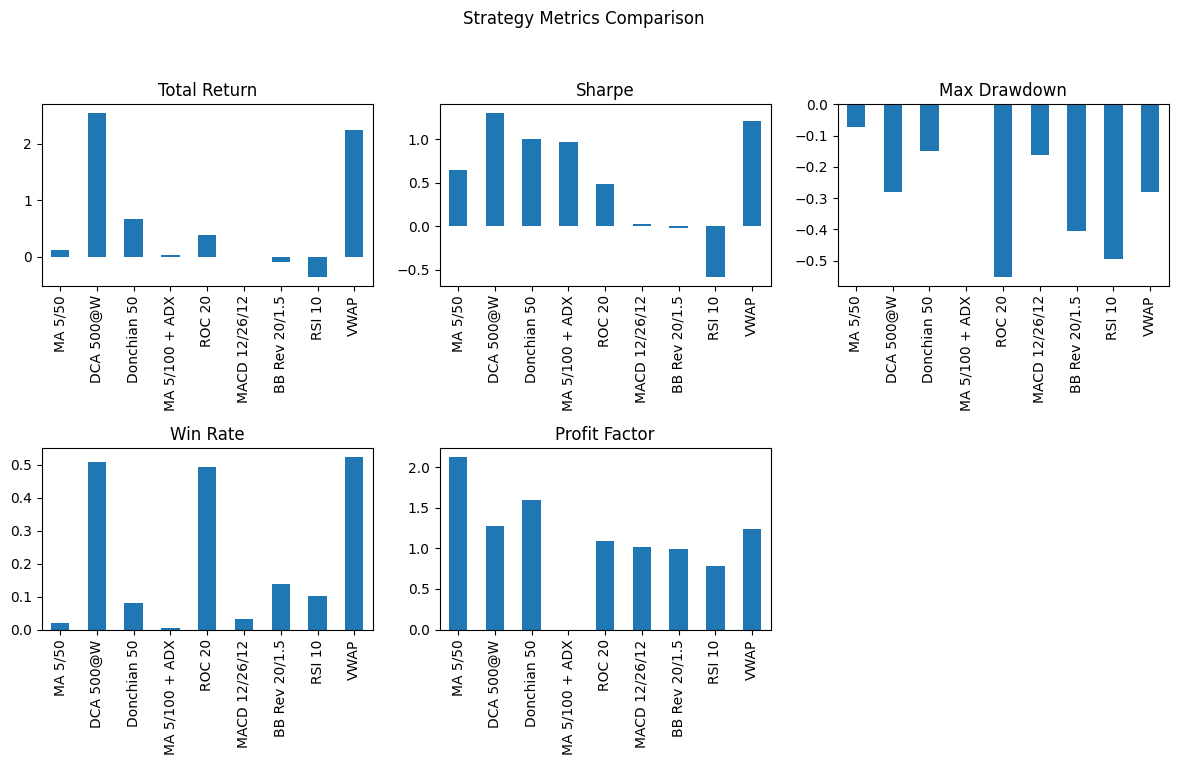

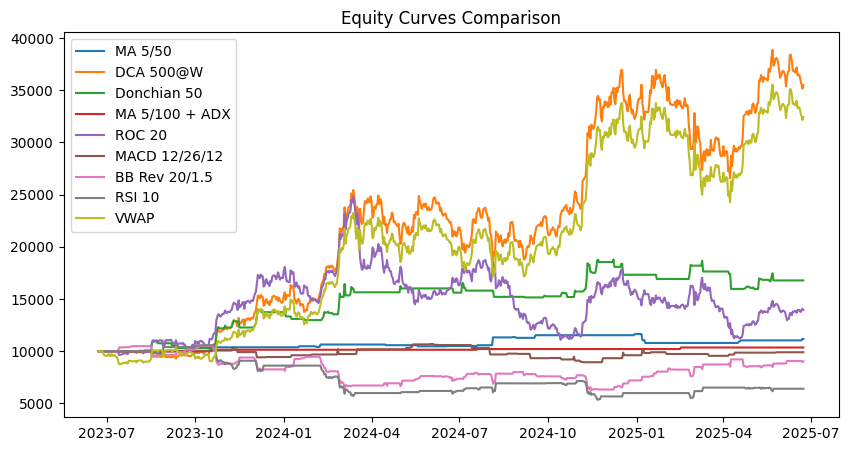

In [2]:
from imports import *
from trading_environment import (
    DataManager,
    Optimizer,
    PerformanceAnalyzer,
    ReportManager,
    DATA_DIR,
    MAX_FILE_SIZE,
    REPORT_DIR
)
from strategies import (
    MovingAverageCrossStrategy,
    DcaStrategy,
    DonchianBreakoutStrategy,
    ADXTrendStrategy,
    ROCStrategy,
    MACDStrategy,
    BollingerMeanRevStrategy,
    RSIStrategy,
    PairTradingStrategy,
    VWAPStrategy
)

# 1) Load data
dm = DataManager(data_dir=DATA_DIR, max_file_size=MAX_FILE_SIZE)
data = dm.load_data(
    symbols='BTC-USD',
    period='2y',
    interval='1d'
)

# 2) Define parameter grids
param_grids = {
    'MA Cross': (
        MovingAverageCrossStrategy,
        {'short_window': [5, 20, 50], 'long_window': [50, 100, 200]}
    ),
    'DCA': (
        DcaStrategy,
        {'amount': [500, 1000, 2000], 'freq': ['D', 'W', 'M']}
    ),
    'Donchian': (
        DonchianBreakoutStrategy,
        {'window': [10, 20, 50]}
    ),
    'ADX + MA': (
        ADXTrendStrategy,
        {'short_w': [5, 20], 'long_w': [50, 100], 'adx_w': [14, 20]}
    ),
    'ROC': (
        ROCStrategy,
        {'window': [5, 10, 20]}
    ),
    'MACD': (
        MACDStrategy,
        {'fast': [8, 12], 'slow': [26, 30], 'signal': [9, 12]}
    ),
    'BB Mean Reversion': (
        BollingerMeanRevStrategy,
        {'window': [10, 20], 'n_std': [1.5, 2, 2.5]}
    ),
    'RSI': (
        RSIStrategy,
        {'window': [10, 14, 20], 'low': [30], 'high': [70]}
    ),
    'Pair Trading': (
        PairTradingStrategy,
        {'pair': [('BTC-USD','ETH-USD')], 'window': [20, 30], 'entry_z': [1.5, 2], 'exit_z': [0, 0.5]}
    ),
    'VWAP': (
        VWAPStrategy,
        {}  # no tunable params
    )
}

best_specs      = {}
best_equities   = {}
best_strategies = {}

# 3) Find the best Sharpe param set for each, via 3 methods
for type_name, (cls, grid) in param_grids.items():
    print(f"\nProcessing strategy type: {type_name}")

    # handle non-tunable
    if not grid:
        try:
            strat = cls()
            eq    = strat.backtest(data)
            sharpe = PerformanceAnalyzer(eq, strat.returns).summary()['Sharpe']
        except Exception as e:
            print(f"{type_name:20s} — all runs failed ({e}), skipping")
            continue

        display_name = strat.name
        print(f"{display_name:20s} — no params, Sharpe = {sharpe:.4f}")

        best_specs[display_name]      = {}
        best_equities[display_name]   = eq
        best_strategies[display_name] = strat
        continue

    opt = Optimizer(cls, grid)

    # --- 3a) Grid search ---
    try:
        grid_df = opt.optimize_grid(data, metric='Sharpe')
    except ValueError as e:
        print(f"{type_name:20s} — Grid: no valid combos ({e}), skipping")
        continue

    # get typed best params from grid
    params_grid = opt.best_params(grid_df, idx=0)
    sharpe_grid = grid_df.loc[0, 'Sharpe']
    print(f"  Grid best    — Sharpe {sharpe_grid:.4f} with {params_grid}")

    # --- 3b) Bayesian optimization (Optuna) ---
    try:
        params_bayes, sharpe_bayes, study = opt.optimize_bayesian(
            data, metric='Sharpe', n_trials=40, seed=42
        )
        print(f"  Bayesian best— Sharpe {sharpe_bayes:.4f} with {params_bayes}")
    except Exception as e:
        print(f"  Bayesian     — failed ({e})")

    # --- 3c) Differential Evolution (SciPy) ---
    if any(not all(isinstance(v,(int,float)) for v in choices)
        for choices in grid.values()):
        print("Skipping DE: non-numeric parameters present")
    else:
        try:
            params_de, sharpe_de, de_res = opt.optimize_de(
                data, metric='Sharpe', maxiter=20, popsize=5
            )
            print(f"  DE best      — Sharpe {sharpe_de:.4f} with {params_de}")
        except Exception as e:
            print(f"  DE           — failed ({e})")

    # final: backtest the grid champion
    strat = cls(**params_grid)
    eq    = strat.backtest(data)
    disp_name = strat.name  # includes params

    best_specs[disp_name]      = params_grid
    best_equities[disp_name]   = eq
    best_strategies[disp_name] = strat

# 4) If nothing succeeded, exit
if not best_equities:
    print("No valid strategies found. Exiting.")
    exit()

# 5) Compare grid-search best strategies
analyzers = {
    name: PerformanceAnalyzer(eq, best_strategies[name].returns)
    for name, eq in best_equities.items()
}

rep_mgr = ReportManager(directory=REPORT_DIR)
comparison_df = rep_mgr.summarize(
    analyzers,
    save=False,
    do_print=True
)

# 6) And plot
rep_mgr.plot_metrics(comparison_df)
rep_mgr.plot_equity_curves(best_equities)


# FIN